# Entorno macroeconómico
$$x^2 - 3$$

In [1]:
# Importar paquetes requeridos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.close('all')

El primer análisis es el del producto interno bruto. Para ello empleamos la serie `pib_trimestral`:

In [2]:
# Cargar bases de datos
pib_trimestral = pd.read_excel('pib.xlsx', engine = 'openpyxl')
pib_trimestral.head()

,periodo,trimestre,pib,importaciones,consumo,gasto,inversion,exportaciones,discrepancia
0,1993,1,1.000889e+07,1458413.400,6094259.456,1410454.426,2311587.205,1421049.137,229957.838
1,1993,2,1.017104e+07,1574506.158,6304689.609,1428916.551,2199172.511,1477720.814,335042.080
2,1993,3,1.006626e+07,1558216.038,6243681.365,1376521.052,2214659.705,1465345.740,324266.582
3,1993,4,1.041610e+07,1717843.240,6598264.978,1423995.127,2355827.803,1588555.613,167295.950
4,1994,1,1.034339e+07,1729058.259,6258192.612,1453656.689,2665717.344,1576502.879,118377.226


La serie `pib_trimestral` contiene observaciones del PIB trimestral *anualizado* de México. Esto quiere decir que cada observación se debe dividir por 4 para obtener el PIB del trimestre. Por tanto, para obtener el PIB anual se debe calcular el promedio de los correspondientes valores trimestrales. Esta nueva serie se llama `pib_anual`:

In [4]:
# Agrupar por periodo y calcular la media:
pib_anual = pib_trimestral
pib_anual = pib_anual.groupby('periodo')
pib_anual = pib_anual.aggregate(np.mean)

# Eliminar la columna 'trimestre' que ya no es necesaria:
pib_anual.pop('trimestre')

pib_anual.head()

,pib,importaciones,consumo,gasto,inversion,exportaciones,discrepancia
periodo,,,,,,,
1993,1.016557e+07,1.577245e+06,6.310224e+06,1.409972e+06,2.270312e+06,1.488168e+06,264140.61250
1994,1.066786e+07,1.857120e+06,6.644794e+06,1.452318e+06,2.598265e+06,1.619055e+06,210548.39250
1995,9.996721e+06,1.561054e+06,6.254226e+06,1.436595e+06,1.785976e+06,1.946071e+06,134905.26825
1996,1.067382e+07,1.833894e+06,6.537721e+06,1.436303e+06,2.067390e+06,2.246699e+06,219606.00675
1997,1.140465e+07,2.257764e+06,7.026836e+06,1.505833e+06,2.358747e+06,2.457556e+06,313437.85300


Si el cálculo es correcto esperamos que se cumpla la identidad contable:
$$ Y = C + I + G + EX - IM + \epsilon$$
donde $Y$ es el PIB (del lado de la oferta), mientras que el lado de la demanda es la suma del consumo ($C$), la inversión ($I$), el gasto público ($G$), las exportaciones ($EX$), las importaciones ($IM$) y la llamada "discrepancia estadística" $\epsilon$.

In [5]:
pib_anual_2 = pib_anual

# Obtener la suma de los componentes del lado de la demanda:
pib_anual_2['suma'] = pib_anual_2['consumo'] + pib_anual_2['inversion'] + pib_anual_2['gasto'] + pib_anual_2['exportaciones'] - pib_anual_2['importaciones'] + pib_anual_2['discrepancia']

# Obtener la diferencia entre el PIB (oferta) y la demanda, que debe ser cero:
pib_anual_2['diferencia'] = round(pib_anual_2['pib'] - pib_anual_2['suma'])
pib_anual_2.loc[:, ['pib', 'suma', 'diferencia']]

# Diferencia máxima y mínima:
(max(pib_anual_2['diferencia']), min(pib_anual_2['diferencia']))

(0.0, 0.0)

<AxesSubplot:xlabel='periodo'>

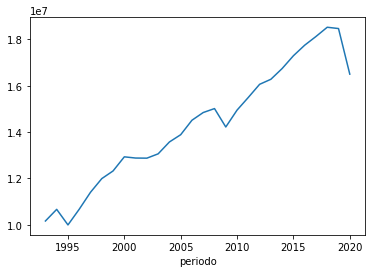

In [15]:
pib_anual['pib'].plot()